In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product k.csv', parse_dates=['Month-Year'])


In [3]:
sales_k= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_k = sales_k.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_k.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,505010,797644,8355561
1,2019-02-01,521132,823109,8622305
2,2019-03-01,580897,917505,9611137
3,2019-04-01,612559,967514,10134996
4,2019-05-01,550697,869805,9111468


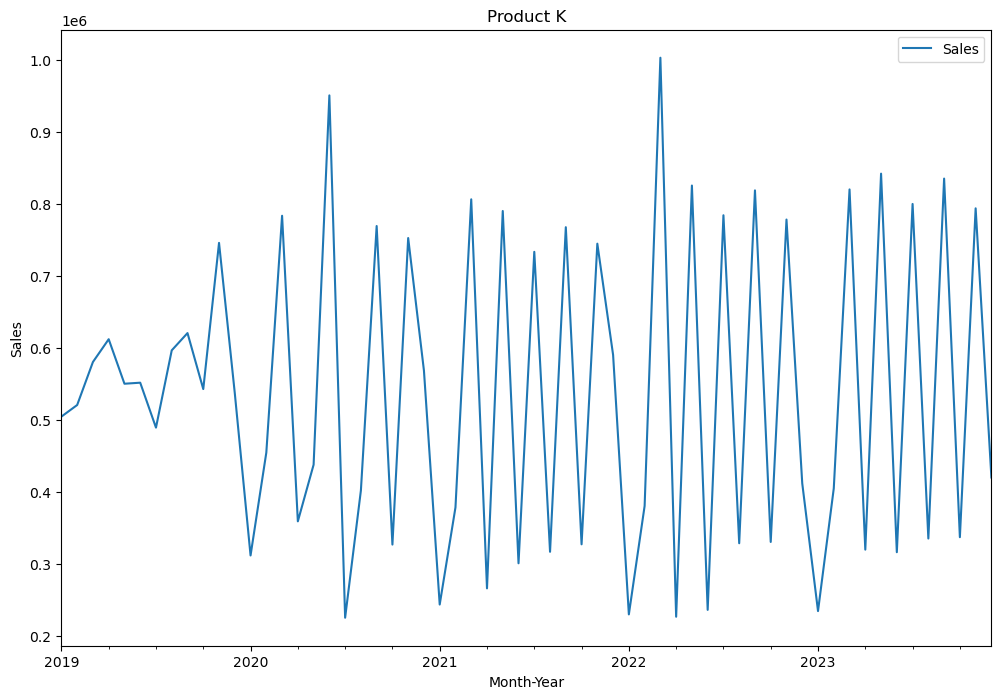

In [5]:
ax = sales_k.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product K')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_k[:48]
test=sales_k[48:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

17:12:38 - cmdstanpy - INFO - Chain [1] start processing
17:12:39 - cmdstanpy - INFO - Chain [1] done processing
17:13:08 - cmdstanpy - INFO - Chain [1] start processing
17:13:10 - cmdstanpy - INFO - Chain [1] done processing
17:13:13 - cmdstanpy - INFO - Chain [1] start processing
17:13:14 - cmdstanpy - INFO - Chain [1] done processing
17:13:17 - cmdstanpy - INFO - Chain [1] start processing
17:13:17 - cmdstanpy - INFO - Chain [1] done processing
17:13:21 - cmdstanpy - INFO - Chain [1] start processing
17:13:21 - cmdstanpy - INFO - Chain [1] done processing
17:13:24 - cmdstanpy - INFO - Chain [1] start processing
17:13:25 - cmdstanpy - INFO - Chain [1] done processing
17:13:28 - cmdstanpy - INFO - Chain [1] start processing
17:13:28 - cmdstanpy - INFO - Chain [1] done processing
17:13:33 - cmdstanpy - INFO - Chain [1] start processing
17:13:34 - cmdstanpy - INFO - Chain [1] done processing
17:13:37 - cmdstanpy - INFO - Chain [1] start processing
17:13:38 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   142910.981262  
1   159748.369935  
2    97622.281658  
3    93192.096324  
4   101052.765636  
.. 

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
71,0.500,10.00,multiplicative,72245.679318
65,0.500,1.00,multiplicative,81137.356813
69,0.500,5.00,multiplicative,84019.803363
64,0.500,1.00,additive,88047.002846
53,0.300,1.00,multiplicative,89509.405812
...,...,...,...,...
37,0.200,0.01,multiplicative,156697.225836
13,0.010,0.01,multiplicative,156788.984062
25,0.100,0.01,multiplicative,156817.038779
1,0.001,0.01,multiplicative,159748.369935


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}


In [24]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.500, seasonality_prior_scale=1.00, seasonality_mode= 'additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [25]:
model.fit(train)

17:31:08 - cmdstanpy - INFO - Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [27]:
future_dates['Market Size'] = sales_k['Market Size']
future_dates['Marketing Expense'] = sales_k['Marketing Expense']

In [28]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,797644,8355561
1,2019-02-01,823109,8622305
2,2019-03-01,917505,9611137
3,2019-04-01,967514,10134996
4,2019-05-01,869805,9111468
5,2019-06-01,872080,9135293
6,2019-07-01,773482,8102450
7,2019-08-01,943094,9879188
8,2019-09-01,980970,10275945
9,2019-10-01,1178924,12349572


In [29]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [30]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [31]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,262670.418014,194735.975525,331203.841258
49,2023-02-01,448348.001028,382954.540384,521120.295592
50,2023-03-01,874263.324663,805187.320892,937505.040306
51,2023-04-01,369153.026653,301064.777580,436895.657702
52,2023-05-01,894819.905575,824263.772516,964185.848084
53,2023-06-01,335025.447762,261622.793793,411693.552363
54,2023-07-01,848479.100373,775240.588098,922419.392391
55,2023-08-01,371843.183424,291663.805755,448672.211667
56,2023-09-01,874191.971179,791153.578377,958384.533366
57,2023-10-01,562348.783628,482887.058011,646320.211449


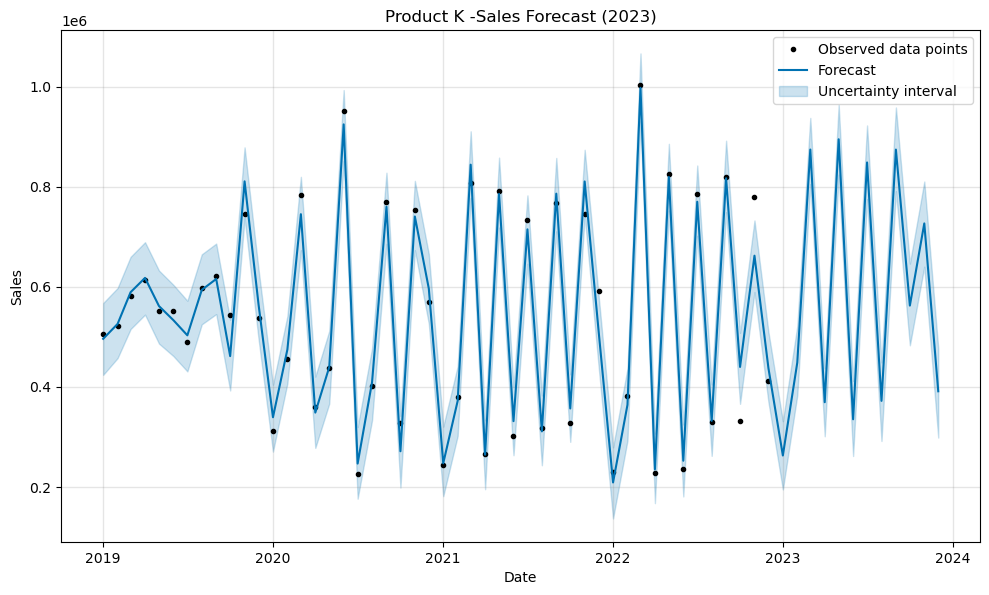

In [32]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product K -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

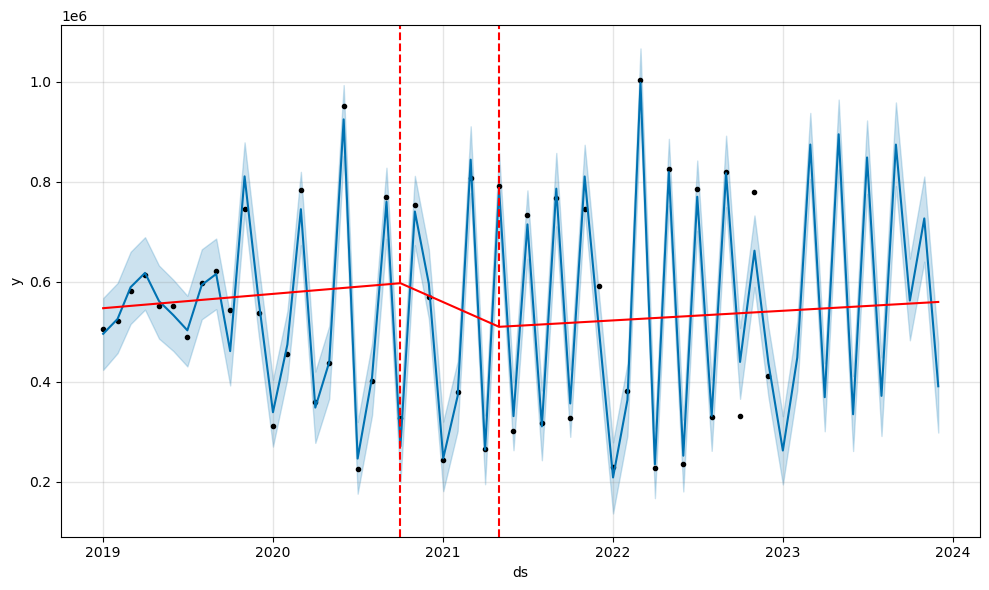

In [33]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

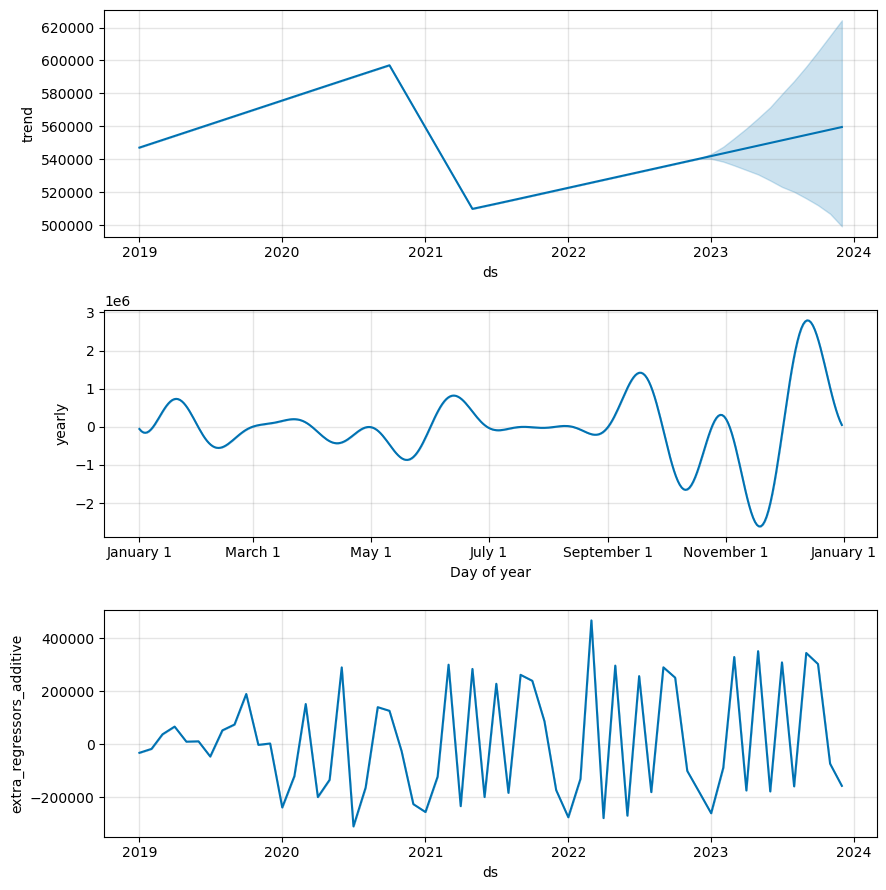

In [34]:
fig2 = model.plot_components(forecast)

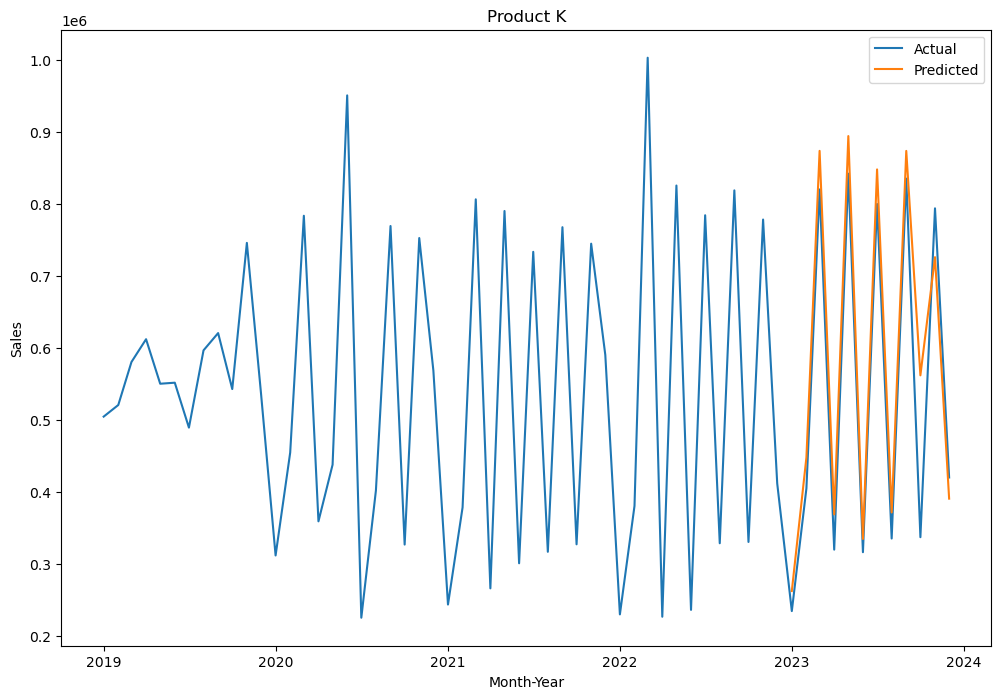

In [35]:
# Reset index of sales_b DataFrame
sales_k_reset_index = sales_k.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_k_reset_index['ds'], sales_k_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product K')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [36]:
#model evaluation

In [37]:
pred=forecasted_df['yhat']
test_df=test['y']

In [38]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 57407.544
MAPE - FB PROPHET: 0.133
MSE - FB PROPHET: 6008209755.851
RMSE - FB PROPHET: 77512.643


In [25]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [26]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,1.291532e+09,35937.885719,35937.885719,0.156116,0.156116,0.169334,1.0
1,62 days,6.963577e+08,26388.590034,26388.590034,0.069286,0.069286,0.071772,1.0
2,90 days,1.851921e+05,430.339566,430.339566,0.000429,0.000429,0.000429,1.0
3,121 days,3.572277e+07,5976.853000,5976.853000,0.026337,0.026337,0.025995,1.0
4,151 days,7.227032e+07,8501.195498,8501.195498,0.010291,0.010291,0.010344,1.0
5,182 days,8.561768e+07,9252.982433,9252.982433,0.039129,0.039129,0.038378,1.0
6,212 days,4.466065e+08,21133.067584,21133.067584,0.026928,0.026928,0.027296,1.0
7,243 days,4.729872e+07,6877.406323,6877.406323,0.020902,0.020902,0.021122,1.0
8,274 days,5.468375e+07,7394.846430,7394.846430,0.009025,0.009025,0.009066,1.0
9,304 days,2.247777e+10,149925.896370,149925.896370,0.453161,0.453161,0.369450,0.0


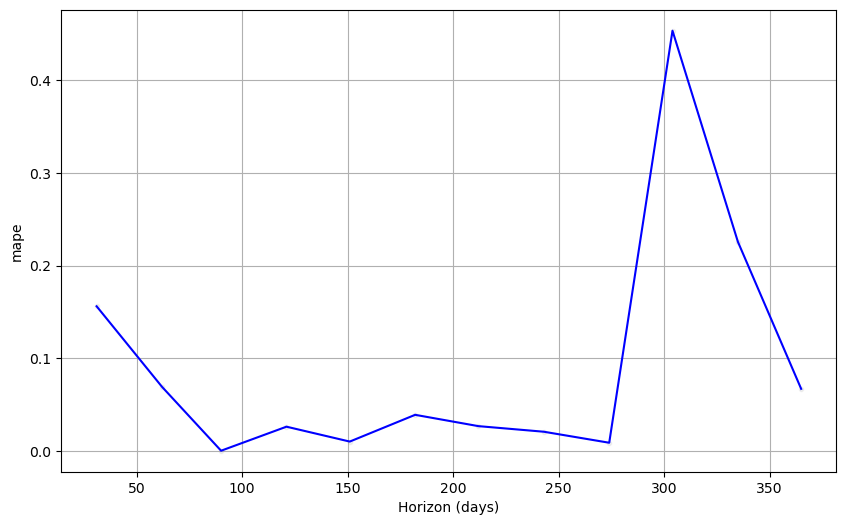

In [27]:
fig = plot_cross_validation_metric(df_cv, metric='mape')